In [4]:
from datetime import datetime, timedelta
import re
from sklearn.metrics import mean_squared_error
import random
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import RFE
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import ShuffleSplit
from sklearn.tree import DecisionTreeClassifier
import shap
from statsmodels.tsa.arima.model import ARIMA 
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

Let's first read the data and visualise the first five rows to get an idea about the data:

In [5]:
sample_df = pd.read_csv(r"/Users/alexfion/sciebo/python_WS/dirty_data.csv")
sample_df.head()

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee
0,ORDC01406,2018-08-07,15:16:03,Lunch,NS,"[('Fries', 6), ('Salad', 4)]",140.80,-37.812539,144.954121,1,8.335,13.700428
1,ORDZ10125,2018-01-12,08:20:16,Breakfast,NS,"[('Cereal', 8), ('Pancake', 6)]",313.50,-37.809310,144.972170,1,7.536,6.167473
2,ORDZ04175,2018-07-06,14:05:04,Lunch,NS,"[('Steak', 3), ('Salad', 1), ('Chicken', 6), (...",714.00,-37.820482,144.994806,0,9.860,15.088928
3,ORDI03691,2018-04-26,11:43:05,Dinner,NS,"[('Pancake', 9), ('Eggs', 10), ('Cereal', 2)]",480.25,-37.818697,144.965774,0,8.614,13.684368
4,ORDZ04094,10-04-2018,11:12:40,Breakfast,NS,"[('Eggs', 5), ('Coffee', 3), ('Pancake', 9), (...",497.75,-37.820609,144.966868,0,8.802,13.760744


The variables, proveded in the dataset, are column names. We can get rid of columns, that are of no interest to us for the future analysis. We want to investigate, how many drivers are needed at a given timepoint, not get any infromation on the customers. 

In [6]:
sample_df.columns

Index(['order_id', 'date', 'time', 'order_type', 'branch_code', 'order_items',
       'order_price', 'customer_lat', 'customer_lon', 'customerHasloyalty?',
       'distance_to_customer_KM', 'delivery_fee'],
      dtype='object')

In [7]:
sample_df=sample_df.drop(columns=['order_type', 'branch_code','customerHasloyalty?','customer_lat','customer_lon'])


To be sure there are no dublicate values, we check if order_id is unique. 

In [8]:
sample_df['order_id'].is_unique


True

We also want to know, how many orders were done at a given date, since the amount of orders is proportionate to the number of drivers needed at the date. For example, on 2018-09-19, number of orders was 5, and they were all performed at 16:37:10.  

In [9]:
sample_df.loc[sample_df['date']=='2018-09-19']['time'].value_counts()

16:37:10    5
Name: time, dtype: int64

However, I imagine that our delivery company has many more deliveries, than 5 per day. Also, it seems unreasonable, that all orders took place at simultaneously. Thus, we need to adapt the data to take place at different times of the day. Thus, we transform our variable "date" to the "new_time". This transformation we do for all unique "dates".

In [10]:
now=datetime.now() 
i=0
unique_dates=sample_df['date'].unique()
for date in unique_dates:
    sample_df.loc[sample_df['date']==date,'new_time']=now+i*timedelta(minutes = 10)
    i=i+1


The new dataframe looks therefore as follows:

In [11]:
sample_df.head()

,order_id,date,time,order_items,order_price,distance_to_customer_KM,delivery_fee,new_time
0,ORDC01406,2018-08-07,15:16:03,"[('Fries', 6), ('Salad', 4)]",140.80,8.335,13.700428,2022-05-20 21:10:40.793195
1,ORDZ10125,2018-01-12,08:20:16,"[('Cereal', 8), ('Pancake', 6)]",313.50,7.536,6.167473,2022-05-20 21:20:40.793195
2,ORDZ04175,2018-07-06,14:05:04,"[('Steak', 3), ('Salad', 1), ('Chicken', 6), (...",714.00,9.860,15.088928,2022-05-20 21:30:40.793195
3,ORDI03691,2018-04-26,11:43:05,"[('Pancake', 9), ('Eggs', 10), ('Cereal', 2)]",480.25,8.614,13.684368,2022-05-20 21:40:40.793195
4,ORDZ04094,10-04-2018,11:12:40,"[('Eggs', 5), ('Coffee', 3), ('Pancake', 9), (...",497.75,8.802,13.760744,2022-05-20 21:50:40.793195


The number of unique order times is now: 

In [12]:
len(sample_df['new_time'].unique())

298

We can thus drop the unnesessary old columns "date" and "time". 

In [13]:
sample_df=sample_df.drop(columns=['date', 'time'])


During these times, orders were made, with the number of unique orders being:

In [14]:
len(sample_df['order_id'].unique())

500

Now let's replace the order ID's with numbers.

In [15]:
i=0
for date in sample_df['order_id'].unique():
    sample_df.loc[sample_df['order_id']==date,'order_id']=i
    i=i+1
sample_df.head()

,order_id,order_items,order_price,distance_to_customer_KM,delivery_fee,new_time
0,0,"[('Fries', 6), ('Salad', 4)]",140.80,8.335,13.700428,2022-05-20 21:10:40.793195
1,1,"[('Cereal', 8), ('Pancake', 6)]",313.50,7.536,6.167473,2022-05-20 21:20:40.793195
2,2,"[('Steak', 3), ('Salad', 1), ('Chicken', 6), (...",714.00,9.860,15.088928,2022-05-20 21:30:40.793195
3,3,"[('Pancake', 9), ('Eggs', 10), ('Cereal', 2)]",480.25,8.614,13.684368,2022-05-20 21:40:40.793195
4,4,"[('Eggs', 5), ('Coffee', 3), ('Pancake', 9), (...",497.75,8.802,13.760744,2022-05-20 21:50:40.793195


We see that order_items contain ordered items, and their amount. I would like to change the representation of the ordered products. 

In [16]:

for i in range(len(sample_df)):
    sample_df['order_items'][i]=re.findall(r"\([^\)]*\)",sample_df['order_items'][i])
split_df = pd.DataFrame(sample_df['order_items'].to_list())
products_df=pd.DataFrame()
for row in range(len(split_df)):
    for nr_products in range(len(split_df.iloc[[row]].dropna(axis=1).columns)):
        result_product = ''.join(filter(str.isalpha, split_df.iloc[[row]][nr_products][row].split()[0]))    
        result_amount = ''.join(filter(str.isnumeric , split_df.iloc[[row]][nr_products][row].split()[1])) 
        if result_product not in products_df:
            
            products_df[result_product]=  np.zeros(shape=(len(split_df),1)).ravel()

        products_df[result_product].iloc[row]=result_amount


Now we can remove the unnecessary "order_items", since we have an improved products_df dataframe, which looks like that:

In [17]:
sample_df=sample_df.drop(columns=['order_items'])
products_df.head()
full_df=pd.concat([sample_df, products_df], axis=1)

In [18]:
full_df

,order_id,order_price,distance_to_customer_KM,delivery_fee,new_time,Fries,Salad,Cereal,Pancake,Steak,Chicken,Burger,Eggs,Coffee,FishChips,Shrimp,Salmon,Pasta
0,0,140.80,8.335,13.700428,2022-05-20 21:10:40.793195,6,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,313.50,7.536,6.167473,2022-05-20 21:20:40.793195,0.0,0.0,8,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,714.00,9.860,15.088928,2022-05-20 21:30:40.793195,4,1,0.0,0.0,3,6,8,0.0,0.0,0.0,0.0,0.0,0.0
3,3,480.25,8.614,13.684368,2022-05-20 21:40:40.793195,0.0,0.0,2,9,0.0,0.0,0.0,10,0.0,0.0,0.0,0.0,0.0
4,4,497.75,8.802,13.760744,2022-05-20 21:50:40.793195,0.0,0.0,7,9,0.0,0.0,0.0,5,3,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,495,781.00,4.425,10.473663,2022-05-22 22:30:40.793195,3,5,0.0,0.0,7,3,8,0.0,0.0,0.0,0.0,0.0,0.0
496,496,281.00,12.011,14.546491,2022-05-21 21:20:40.793195,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,6,0.0
497,497,225.00,8.975,14.450127,2022-05-22 22:40:40.793195,0.0,0.0,0.0,2,0.0,0.0,0.0,7,3,0.0,0.0,0.0,0.0
498,498,742.00,9.772,13.555158,2022-05-21 20:20:40.793195,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,1,8,8


Now we count how many orders were done at a certain time point and remove repeated rows, since we are not interested in single orders.

In [19]:
for unique_date in full_df['new_time'].unique():
    full_df.loc[full_df['new_time']==unique_date,'order_time_frequency'] = full_df.loc[full_df['new_time']==unique_date]['new_time'].value_counts()[0]


In [20]:
full_df=full_df.drop_duplicates(subset=['new_time'], keep='last')
full_df

,order_id,order_price,distance_to_customer_KM,delivery_fee,new_time,Fries,Salad,Cereal,Pancake,Steak,Chicken,Burger,Eggs,Coffee,FishChips,Shrimp,Salmon,Pasta,order_time_frequency
0,0,140.80,8.335,13.700428,2022-05-20 21:10:40.793195,6,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,3,480.25,8.614,13.684368,2022-05-20 21:40:40.793195,0.0,0.0,2,9,0.0,0.0,0.0,10,0.0,0.0,0.0,0.0,0.0,1.0
4,4,497.75,8.802,13.760744,2022-05-20 21:50:40.793195,0.0,0.0,7,9,0.0,0.0,0.0,5,3,0.0,0.0,0.0,0.0,1.0
9,9,417.25,8.624,15.758749,2022-05-20 22:40:40.793195,0.0,0.0,8,3,0.0,0.0,0.0,7,3,0.0,0.0,0.0,0.0,1.0
11,11,219.00,8.722,13.313938,2022-05-20 23:00:40.793195,0.0,0.0,1,0.0,0.0,0.0,0.0,9,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,495,781.00,4.425,10.473663,2022-05-22 22:30:40.793195,3,5,0.0,0.0,7,3,8,0.0,0.0,0.0,0.0,0.0,0.0,1.0
496,496,281.00,12.011,14.546491,2022-05-21 21:20:40.793195,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,6,0.0,3.0
497,497,225.00,8.975,14.450127,2022-05-22 22:40:40.793195,0.0,0.0,0.0,2,0.0,0.0,0.0,7,3,0.0,0.0,0.0,0.0,1.0
498,498,742.00,9.772,13.555158,2022-05-21 20:20:40.793195,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,1,8,8,5.0


Actually, we are not interested in any other features, we try to predict the number of frequencies based on the time series analysis. Thus, I made a separate dataframe "time_series", which consists of time of orders and order number at this time. 

In [21]:
time_series=full_df[['new_time','order_time_frequency']]
time_series=time_series.drop_duplicates()
time_series


,new_time,order_time_frequency
0,2022-05-20 21:10:40.793195,1.0
3,2022-05-20 21:40:40.793195,1.0
4,2022-05-20 21:50:40.793195,1.0
9,2022-05-20 22:40:40.793195,1.0
11,2022-05-20 23:00:40.793195,1.0
...,...,...
495,2022-05-22 22:30:40.793195,1.0
496,2022-05-21 21:20:40.793195,3.0
497,2022-05-22 22:40:40.793195,1.0
498,2022-05-21 20:20:40.793195,5.0


Now we want to modulate the order frequency and artificially introduce some randomness, and plot the order-time dependence.

In [22]:
time_series['order_time_frequency']=time_series['order_time_frequency']*100
index=time_series.sample(n=150).index
time_series.loc[index,'order_time_frequency']=time_series['order_time_frequency'][index]*0.5
index=time_series.sample(n=150).index
time_series.loc[index,'order_time_frequency']=time_series['order_time_frequency'][index]*0.75
index=time_series.sample(n=150).index
time_series.loc[index,'order_time_frequency']=time_series['order_time_frequency'][index]*0.4
time_series.sort_values(by='new_time')

,new_time,order_time_frequency
0,2022-05-20 21:10:40.793195,75.0
477,2022-05-20 21:20:40.793195,30.0
345,2022-05-20 21:30:40.793195,225.0
3,2022-05-20 21:40:40.793195,50.0
4,2022-05-20 21:50:40.793195,100.0
...,...,...
483,2022-05-22 22:00:40.793195,37.5
486,2022-05-22 22:10:40.793195,30.0
488,2022-05-22 22:20:40.793195,37.5
495,2022-05-22 22:30:40.793195,15.0


<AxesSubplot:xlabel='Date', ylabel='# orders'>

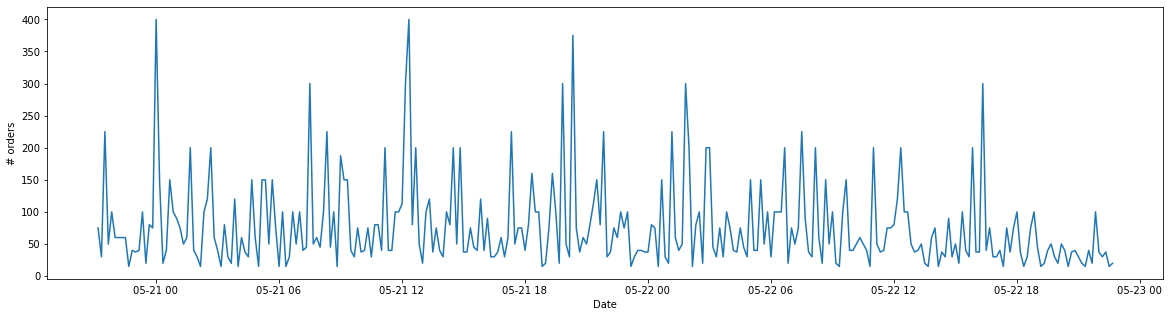

In [23]:
plt.figure(figsize=(20,5))
plt.ylabel('# orders')
plt.xlabel('Date')
sns.lineplot(time_series['new_time'],time_series['order_time_frequency'])


Further I artificially introduced two wariables, which are related to each other, and which depend on number of orders at a given time. First variable is the "delivery time", and the second one is "drivers". I.e., if the number of orders is under 50, the delivery time will be 30 min, and the number of drivers, needed to deliver the goods, would be 10. Further, Gaussian noise was added to the values in these variables. This approach is very exploratory, since in the real problem, this data would be provided. This information would be needed to understand in detail how many drivers the company employs in order to fulfill their demand.  

In [24]:
time_series.loc[time_series['order_time_frequency']<50,'delivery time']=30
time_series.loc[time_series['order_time_frequency']<50,'drivers']=10
time_series.loc[time_series['order_time_frequency']>=50,'delivery time']=45
time_series.loc[time_series['order_time_frequency']>=50,'drivers']=30
time_series.loc[time_series['order_time_frequency']>=100,'delivery time']=60
time_series.loc[time_series['order_time_frequency']>=100,'drivers']=40
time_series.loc[time_series['order_time_frequency']>=150,'delivery time']=70
time_series.loc[time_series['order_time_frequency']>=150,'drivers']=50
time_series.loc[time_series['order_time_frequency']>=250,'delivery time']=100
time_series.loc[time_series['order_time_frequency']>=250,'drivers']=70
time_series.loc[time_series['order_time_frequency']>=350,'delivery time']=120
time_series.loc[time_series['order_time_frequency']>=350,'drivers']=120

In [25]:
#added gauss noise to drivers
index=time_series.sample(n=50).index
time_series.loc[index,'drivers']=time_series['drivers'][index]+round(random.gauss(20, 1.5))
index=time_series.sample(n=100).index
time_series.loc[index,'drivers']=time_series['drivers'][index]+round(random.gauss(15, 2.5))
index=time_series.sample(n=200).index
time_series.loc[index,'drivers']=time_series['drivers'][index]+round(random.gauss(5, 3.5))

In [26]:
#added gauss noise to drivers
index=time_series.sample(n=50).index
time_series.loc[index,'delivery time']=time_series['delivery time'][index]+round(random.gauss(20, 1.5))
index=time_series.sample(n=100).index
time_series.loc[index,'delivery time']=time_series['delivery time'][index]+round(random.gauss(15, 2.5))
index=time_series.sample(n=200).index
time_series.loc[index,'delivery time']=time_series['delivery time'][index]+round(random.gauss(5, 3.5))

No handles with labels found to put in legend.


<AxesSubplot:xlabel='Date', ylabel='# units'>

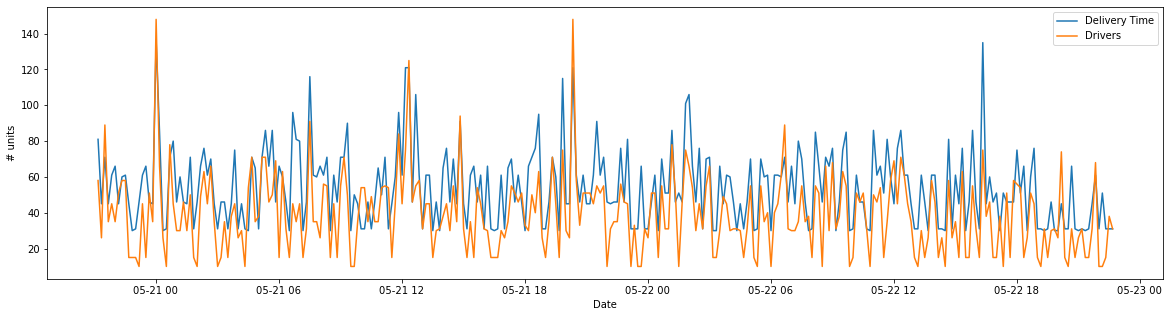

In [27]:
#This is how these variables looks like
plt.figure(figsize=(20,5))
plt.ylabel('# units')
plt.xlabel('Date')
plt.legend()
sns.lineplot(time_series['new_time'],time_series['delivery time'], label='Delivery Time')
sns.lineplot(time_series['new_time'],time_series['drivers'], label='Drivers')


In [28]:
time_series.loc[time_series['new_time']==date,'order_time_frequency'].values

array([], dtype=float64)

In [29]:
#adapt the initial dataframe (full_df) with the number of orders
for date in time_series['new_time'].values:
    full_df.loc[full_df['new_time']==date,'order_time_frequency']=time_series.loc[time_series['new_time']==date,'order_time_frequency'].values  
full_df.columns

Index(['order_id', 'order_price', 'distance_to_customer_KM', 'delivery_fee',
       'new_time', 'Fries', 'Salad', 'Cereal', 'Pancake', 'Steak', 'Chicken',
       'Burger', 'Eggs', 'Coffee', 'FishChips', 'Shrimp', 'Salmon', 'Pasta',
       'order_time_frequency'],
      dtype='object')

In [30]:
for column in full_df.drop(columns=["order_id",'new_time','distance_to_customer_KM','delivery_fee']).columns:
    for date in full_df['new_time'].values:
        time_series.loc[time_series['new_time']==date,'average_'+str(column)]=np.average(list(map(int,full_df.loc[full_df['new_time']==date,column].values)))  


In [31]:
for date in full_df['new_time'].values: 
    time_series.loc[time_series['new_time']==date,'average_delivery_distance']=np.average(full_df.loc[full_df['new_time']==date,'distance_to_customer_KM'].values)
    time_series.loc[time_series['new_time']==date,'average_delivery_fee']=np.average(full_df.loc[full_df['new_time']==date,'delivery_fee'].values)
        

In [32]:
time_series

,new_time,order_time_frequency,delivery time,drivers,average_order_price,average_Fries,average_Salad,average_Cereal,average_Pancake,average_Steak,...,average_Burger,average_Eggs,average_Coffee,average_FishChips,average_Shrimp,average_Salmon,average_Pasta,average_order_time_frequency,average_delivery_distance,average_delivery_fee
0,2022-05-20 21:10:40.793195,75.0,81.0,58.0,140.0,6.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,75.0,8.335,13.700428
3,2022-05-20 21:40:40.793195,50.0,45.0,35.0,480.0,0.0,0.0,2.0,9.0,0.0,...,0.0,10.0,0.0,0.0,0.0,0.0,0.0,50.0,8.614,13.684368
4,2022-05-20 21:50:40.793195,100.0,61.0,45.0,497.0,0.0,0.0,7.0,9.0,0.0,...,0.0,5.0,3.0,0.0,0.0,0.0,0.0,100.0,8.802,13.760744
9,2022-05-20 22:40:40.793195,15.0,45.0,15.0,417.0,0.0,0.0,8.0,3.0,0.0,...,0.0,7.0,3.0,0.0,0.0,0.0,0.0,15.0,8.624,15.758749
11,2022-05-20 23:00:40.793195,37.5,31.0,15.0,219.0,0.0,0.0,1.0,0.0,0.0,...,0.0,9.0,0.0,0.0,0.0,0.0,0.0,37.0,8.722,13.313938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,2022-05-22 22:30:40.793195,15.0,31.0,38.0,781.0,3.0,5.0,0.0,0.0,7.0,...,8.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,4.425,10.473663
496,2022-05-21 21:20:40.793195,112.5,61.0,45.0,281.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,6.0,0.0,112.0,12.011,14.546491
497,2022-05-22 22:40:40.793195,20.0,31.0,31.0,225.0,0.0,0.0,0.0,2.0,0.0,...,0.0,7.0,3.0,0.0,0.0,0.0,0.0,20.0,8.975,14.450127
498,2022-05-21 20:20:40.793195,375.0,121.0,148.0,742.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.0,1.0,8.0,8.0,375.0,9.772,13.555158


Now I wanted to introduce some additional features to the dataset by splitting new_time in months, days, weekdays, hours and minutes. It would be interesting to test if we can predict anything based on these non-sense deatures (just for fun). 

In [33]:
time_series["pickup_month"] = time_series["new_time"].dt.month
time_series["pickup_day"] = time_series["new_time"].dt.day
time_series["pickup_weekday"] = time_series["new_time"].dt.weekday 
time_series["pickup_hour"] = time_series["new_time"].dt.hour
time_series["pickup_minute"] = time_series["new_time"].dt.minute


This is how the dataframe looks now:

In [34]:
time_series

,new_time,order_time_frequency,delivery time,drivers,average_order_price,average_Fries,average_Salad,average_Cereal,average_Pancake,average_Steak,...,average_Salmon,average_Pasta,average_order_time_frequency,average_delivery_distance,average_delivery_fee,pickup_month,pickup_day,pickup_weekday,pickup_hour,pickup_minute
0,2022-05-20 21:10:40.793195,75.0,81.0,58.0,140.0,6.0,4.0,0.0,0.0,0.0,...,0.0,0.0,75.0,8.335,13.700428,5,20,4,21,10
3,2022-05-20 21:40:40.793195,50.0,45.0,35.0,480.0,0.0,0.0,2.0,9.0,0.0,...,0.0,0.0,50.0,8.614,13.684368,5,20,4,21,40
4,2022-05-20 21:50:40.793195,100.0,61.0,45.0,497.0,0.0,0.0,7.0,9.0,0.0,...,0.0,0.0,100.0,8.802,13.760744,5,20,4,21,50
9,2022-05-20 22:40:40.793195,15.0,45.0,15.0,417.0,0.0,0.0,8.0,3.0,0.0,...,0.0,0.0,15.0,8.624,15.758749,5,20,4,22,40
11,2022-05-20 23:00:40.793195,37.5,31.0,15.0,219.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,37.0,8.722,13.313938,5,20,4,23,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,2022-05-22 22:30:40.793195,15.0,31.0,38.0,781.0,3.0,5.0,0.0,0.0,7.0,...,0.0,0.0,15.0,4.425,10.473663,5,22,6,22,30
496,2022-05-21 21:20:40.793195,112.5,61.0,45.0,281.0,0.0,0.0,0.0,0.0,0.0,...,6.0,0.0,112.0,12.011,14.546491,5,21,5,21,20
497,2022-05-22 22:40:40.793195,20.0,31.0,31.0,225.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,20.0,8.975,14.450127,5,22,6,22,40
498,2022-05-21 20:20:40.793195,375.0,121.0,148.0,742.0,0.0,0.0,0.0,0.0,0.0,...,8.0,8.0,375.0,9.772,13.555158,5,21,5,20,20


Now I am satisfied with the transformations and I want to do some prediction on the data. I want to predict the number of drivers based on all other features. 

In [35]:
X = time_series.drop(["drivers","new_time"], axis=1)
y = time_series["drivers"]
X

,order_time_frequency,delivery time,average_order_price,average_Fries,average_Salad,average_Cereal,average_Pancake,average_Steak,average_Chicken,average_Burger,...,average_Salmon,average_Pasta,average_order_time_frequency,average_delivery_distance,average_delivery_fee,pickup_month,pickup_day,pickup_weekday,pickup_hour,pickup_minute
0,75.0,81.0,140.0,6.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,75.0,8.335,13.700428,5,20,4,21,10
3,50.0,45.0,480.0,0.0,0.0,2.0,9.0,0.0,0.0,0.0,...,0.0,0.0,50.0,8.614,13.684368,5,20,4,21,40
4,100.0,61.0,497.0,0.0,0.0,7.0,9.0,0.0,0.0,0.0,...,0.0,0.0,100.0,8.802,13.760744,5,20,4,21,50
9,15.0,45.0,417.0,0.0,0.0,8.0,3.0,0.0,0.0,0.0,...,0.0,0.0,15.0,8.624,15.758749,5,20,4,22,40
11,37.5,31.0,219.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,37.0,8.722,13.313938,5,20,4,23,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,15.0,31.0,781.0,3.0,5.0,0.0,0.0,7.0,3.0,8.0,...,0.0,0.0,15.0,4.425,10.473663,5,22,6,22,30
496,112.5,61.0,281.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.0,0.0,112.0,12.011,14.546491,5,21,5,21,20
497,20.0,31.0,225.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,20.0,8.975,14.450127,5,22,6,22,40
498,375.0,121.0,742.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.0,8.0,375.0,9.772,13.555158,5,21,5,20,20


I'm treating my data as a time series, and apply some time series analytics tools. Let's create a new dataframe, just for this analysis. Further, we estimate rolling mean and standard deviation. Rolling mean is .... 

In [39]:
series=pd.DataFrame()
series['date']=time_series["new_time"]
series['drivers']=y
series.date = pd.to_datetime(series.date)
print(series.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 298 entries, 0 to 499
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     298 non-null    datetime64[ns]
 1   drivers  298 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 15.1 KB
None


In [61]:
series=series.sort_values(by=['date'])

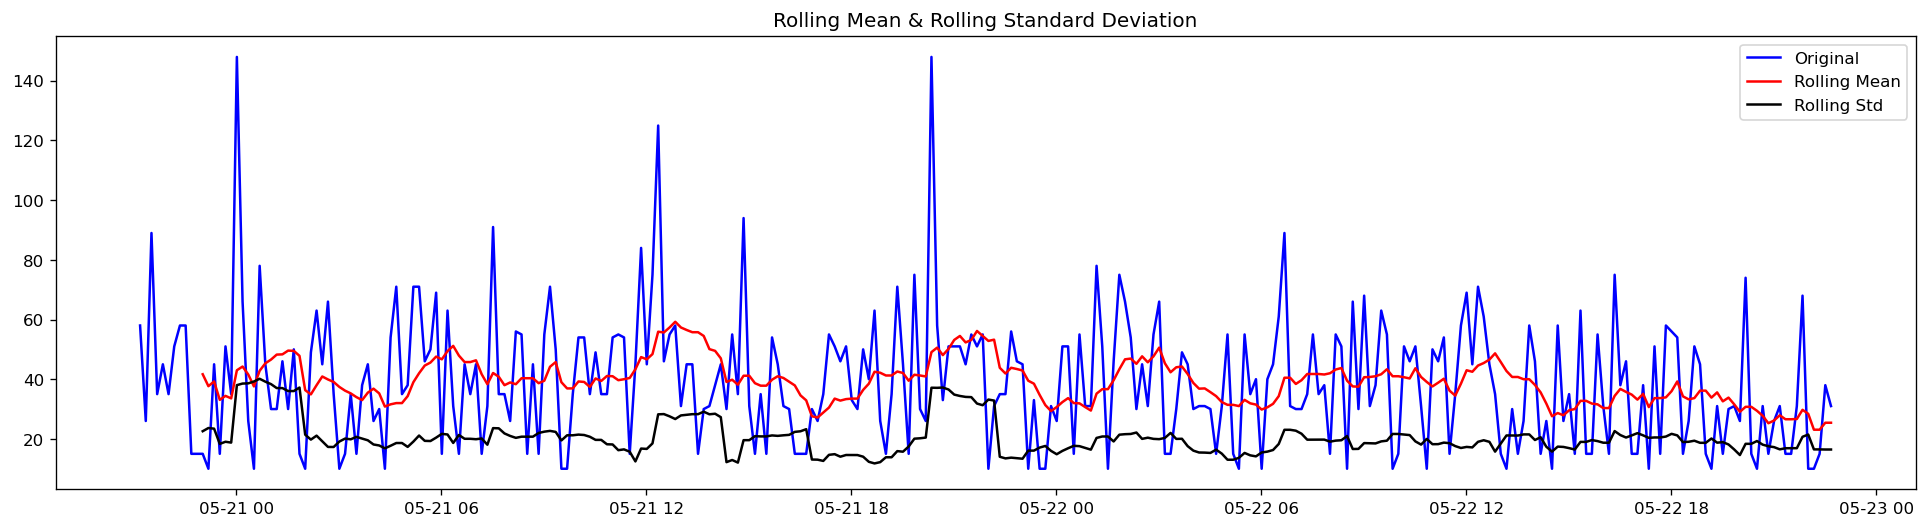

In [62]:

rolling_mean = series.rolling(window = 12).mean()
rolling_std = series.drivers.rolling(window = 12).std()
plt.figure(figsize=(20,5))
plt.plot(series.date,series.drivers, color = 'blue', label = 'Original')
plt.plot(series.date,rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(series.date,rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

Further we perform the Augmented Dickey-Fuller unit root test, to check if the stationarity exists in the series. This test is necessary to see, which analysis can be applied to the time series for prediction. Since the p-value is smaller than 0.05, we can reject the null hypothesis, which states that non stationarity exists in the series. Therefore, we proceed under assumption that the dataset is stationary.

In [64]:
result = adfuller(series['drivers'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -15.418769461299416
p-value: 3.054311113593876e-28
Critical Values:
	1%: -3.4525611751768914
	5%: -2.87132117782556
	10%: -2.5719816428028888


Let’s see how well a standard ARIMA model performs on the time series. We estimate its RMSE, and plot prediction vs actual data. 


In [67]:
X = series['drivers'].values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
        model = ARIMA(history, order=(4,1,0))
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
        print('predicted=%f, expected=%f' % (yhat, obs))


predicted=30.614341, expected=40.000000
predicted=34.369675, expected=10.000000
predicted=24.962259, expected=40.000000
predicted=40.742526, expected=45.000000
predicted=32.189547, expected=61.000000
predicted=42.186553, expected=89.000000
predicted=51.424589, expected=31.000000
predicted=46.482762, expected=30.000000
predicted=53.660187, expected=30.000000
predicted=45.381938, expected=35.000000
predicted=45.357324, expected=55.000000
predicted=38.420894, expected=35.000000
predicted=34.324686, expected=38.000000
predicted=40.024411, expected=15.000000
predicted=31.475642, expected=55.000000
predicted=45.466233, expected=51.000000
predicted=36.420069, expected=10.000000
predicted=31.510347, expected=66.000000
predicted=44.857615, expected=30.000000
predicted=35.679464, expected=68.000000
predicted=52.930008, expected=31.000000
predicted=33.442291, expected=38.000000
predicted=50.610091, expected=63.000000
predicted=45.502619, expected=55.000000
predicted=51.152873, expected=10.000000


Test RMSE: 20.860


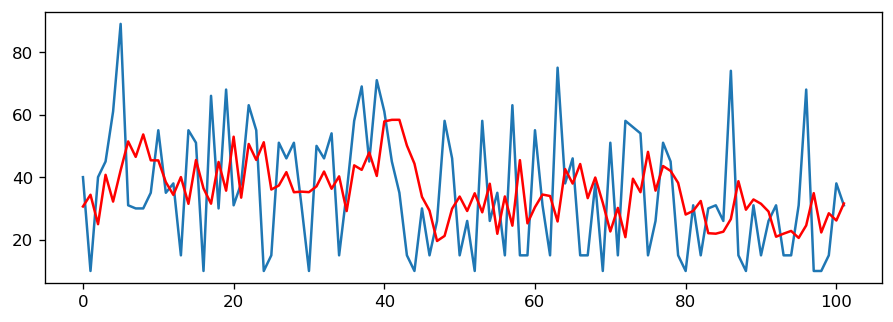

In [68]:
# evaluate forecasts
rmse = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()